In [1]:
import numpy as np
import iminuit
import scipy.optimize as optimize
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [2]:
class JFET:
    def __init__(self, W_L_ratio, a, N_d, E_g=1.12, alpha=5.4e-4, beta=655, eps_s=11.9, T_0=300):
        """
        Class that simulate JFETs with explicit temperature dependance

        Parameters:
        -----------
        W_L_ratio : float
            Ratio betweem channel width and channel lenght
        a : float
            Channel depth [m]
        N_d : float
            Donor doping concentration [cm^-3]
        E_g : float
            Bandgap energy [eV]
        alpha : float 
            Parameter to adjust E_g with temperature [eV/K]
        beta : float
            Parameter to adjust E_g with temperature [K]
        eps_s : float
            Dieletric constant of the semiconductor
        T_0 : float
            Reference temperature [K]
        """

        self.W_L_ratio = W_L_ratio
        self.a = a
        self.N_d = N_d
        self.E_g = E_g
        self.alpha = alpha
        self.beta = beta
        self.eps_s = eps_s
        self.T_0 = T_0

        self.k_b = 1.38e-23         # Boltzmann constant [J/K]
        self.h  = 6.626e-34         # Planck constant [J·s]
        self.q = 1.6e-19            # Electron charge [C]
        self.m_0 = 9.1095e-31       # Electron mass [kg]
        self.eps_0 = 8.85e-12       # Vacuum permittivity [F/m]

    def safe_power(self, x, p, tol=1e-8):
        """
        Safely compute x^p for both scalar and array inputs.
        
        - For integer exponents: Preserve sign (negative inputs allowed)
        - For fractional exponents: Clamp negative inputs to 0 to avoid NaNs
        
        Parameters:
        -----------
        x : scalar or array-like
            Input values
        p : float
            Exponent
        tol : float, optional
            Tolerance for checking if exponent is an integer
        
        Returns:
        --------
        scalar or ndarray
            Result of x^p with safety checks
        """
        x = np.asarray(x)
        p_rounded = np.round(p)
        is_integer = np.isclose(p, p_rounded, atol=tol)
        
        if is_integer:
            # Integer exponent: preserve sign for odd exponents
            p_int = int(p_rounded)
            abs_result = np.abs(x) ** p_int
            if p_int % 2 == 1:  # Odd exponent
                return np.sign(x) * abs_result
            else:  # Even exponent
                return abs_result
        else:
            # Fractional exponent: clamp negative values to 0
            x_clamped = np.maximum(x, 0)
            return x_clamped ** p
    
    def density_of_states_cond_band(self, T):
        """
        Calculate the number of states in the conduction band as function of temperature
        """
        M_c = 6
        m_l = 0.98*self.m_0
        m_t = 0.19*self.m_0
        m_de = (m_l * m_t**2)**(1/3)

        num = 2*np.pi * m_de * self.k_b * T
        den = self.h**2

        return (2* M_c*(num/den)**1.5)*1e-6  # result in cmˆ-3
    
    def energy_gap(self, T):
        """
        Calculate the energy gap as a function of temperature
        """
        E_g_0 = 1.169      

        return E_g_0 - (self.alpha * T**2) / (T + self.beta)

    def built_in_potential(self, T):
        """
        Calculate the built-in potential as a function of temperature
        """
        N_c = self.density_of_states_cond_band(T) 
        N_c_m3 = N_c * 1e6 # convert from cm^-3 to m^-3
        N_d_m3 = self.N_d * 1e6  # Convert from cm^-3 to m^-3
        E_g_T = self.energy_gap(T)
        E_g_T_J = E_g_T * self.q # convert in J
        ln_term = np.log(N_c_m3 / N_d_m3)

        return (E_g_T_J - self.k_b * T * ln_term)/self.q

    def pinch_off_voltage(self):
        """
        Calculate the pinch-off voltage for the JFET
        """
        N_d_m3 = self.N_d * 1e6  # Convert from cm^-3 to m^-3

        return (self.q * N_d_m3 * self.a**2) / (2 * self.eps_s * self.eps_0)

    
    def mobility(self, T):
        """
        Calculate electrons mobility as a function of temperature
        """       
        m_alpha = 1.5
        m_beta = 3.13
        mu_0ea = 4195  # cm^2/V s
        mu_0eb = 2153  # cm^2/V s

        rateo = T / self.T_0
        A = 1 / (mu_0ea * rateo**(-m_alpha))
        B = 1 / (mu_0eb * rateo**(-m_beta))

        return 1/(A+B)
    
    def full_channel_conductance(self, mu):
        """
        Calculate the full-channel conductance
        """
        N_d_m3 = self.N_d * 1e6  # Convert from cm^-3 to m^-3
        mu_m = mu *1e-4 # convert from cmˆ-2 to mˆ-2

        return self.W_L_ratio * self.q * N_d_m3 * self.a * mu_m

    def I_d(self, V_ds, V_gs, T, lambda_mod=0):
        """
        Calculate the drain-source current for given conditions

        Parameters:
        -----------
        V_ds : scalar or array
            Drain-source voltage [V]
        V_gs : scalar or array
            Gate-source voltage [V]
        T : float
            Temperature [K]
        lambda_mod : float, optional
            Channel-length modulation factor

        Returns:
        --------
        array
            Drain-Source current [A]
        """

        V_bi = self.built_in_potential(T)
        V_p = self.pinch_off_voltage()
        mu = self.mobility(T)
        G = self.full_channel_conductance(mu)

        V_T = V_bi - V_p            # Threshold voltage
        V_sat = V_p - V_bi + V_gs   # Saturation voltage

        V_ds = np.asarray(V_ds)
        V_gs = np.asarray(V_gs)

        I_d = np.zeros_like(V_ds)

        # Regions definition
        linear_region = V_gs >= V_T
        saturation_region = (V_ds >= V_sat) & linear_region

        # Linear region
        I_d[linear_region] = (
            G * (
                V_ds[linear_region]
                - (2 / (3 * np.sqrt(V_p))) * self.safe_power(V_bi + V_ds[linear_region] - V_gs[linear_region], 1.5)
                + (2 / (3 * np.sqrt(V_p))) * self.safe_power(V_bi - V_gs[linear_region], 1.5)
                )
            )
        # Saturation region
        I_d[saturation_region] = (
            G * (
                V_sat[saturation_region]
                - (2 / (3 * np.sqrt(V_p))) * self.safe_power(V_bi + V_sat[saturation_region] - V_gs[saturation_region], 1.5)
                + (2 / (3 * np.sqrt(V_p))) * self.safe_power(V_bi - V_gs[saturation_region], 1.5)
                )
            ) * (1 + lambda_mod * (V_ds[saturation_region] - V_sat[saturation_region]))

        return I_d
    
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------

def infer_jfet_params(I_DSS, VTO, g_m, T, method='differential_evolution'):
    """
    Function that infers donor concentration and geometric channel parameters starting from JFET data sheet values
    
    Parameters:
    -----------
    I_DSS : float
        Saturation current @ V_gs = 0 [A]
    VTO : float
        Pinch off voltage [V]
    g_m : float
        Transconductance [S]
    T : float
        Nominal data sheet temperature [K]
    method : str, optional
        Optimization method to use. Options:
        - 'differential_evolution' (default): Uses SciPy's differential evolution
        - 'iminuit': Uses iMinuit for optimization (requires iminuit to be installed)
    
    Returns:
    --------
    dict
        Inferred parameters, including:
        - 'N_d': Donor concentration
        - 'W_L_ratio': Channel width and length ratio
        - 'a': Channel depth
        - 'covariance_matrix': Covariance matrix (only returned when method='iminuit')
    """
    
    k_b = 1.38e-23          # Boltzmann constant 
    h = 6.626e-34           # Planck constant
    q = 1.6e-19             # Electron charge [C]
    m_0 = 9.1095e-31        # Electron mass
    T_0 = 300               # Reference temperature [K]
    
    def mobility(T):
        m_alpha = 1.5
        m_beta = 3.13
        mu_0a = 4195  # cm^2/V s
        mu_0b = 2153  # cm^2/V s
        rateo = T / T_0
        A = 1/(mu_0a * rateo**(-m_alpha))
        B = 1/(mu_0b * rateo**(-m_beta))
        return 1/(A + B)
    
    def density_of_states_cond_band(T):
        M_c = 6
        m_l = 0.98*m_0
        m_t = 0.19*m_0
        m_de = (m_l * m_t**2)**(1/3) 

        num = 2*np.pi * m_de * k_b * T
        den = h**2

        return (2 * M_c * (num/den)**1.5) * 1e-6  # Convert from m^-3 to cm^-3
    
    def energy_gap(T):
        alpha = 5.4e-4         # Parameter to adjust E_g with temperature [eV/K]
        beta = 655             # Parameter to adjust E_g with temperature [K]
        E_g_0 = 1.169
        return E_g_0 - (alpha * T**2) / (T + beta)
    
    def built_in_potential(T, N_d):
        N_c = density_of_states_cond_band(T) 
        N_c_m3 = N_c * 1e6     # Convert from cm^-3 to m^-3
        N_d_m3 = N_d * 1e6     # Convert from cm^-3 to m^-3
        E_g_T = energy_gap(T)
        E_g_T_J = E_g_T * q
        ln_term = np.log(N_c_m3 / N_d_m3)

        return (E_g_T_J - k_b * T * ln_term)/q
    
    def pinch_off_voltage(N_d, a):
        eps_0 = 8.85e-12        # Vacuum permittivity [F/m]
        eps_s = 11.9            # Relative permittivity of Si 
        N_d_m3 = N_d * 1e6      # Convert from cm^-3 to m^-3
        return (q * N_d_m3 * a**2) / (2 * eps_s * eps_0)
    
    def full_channel_conductance(mu, N_d, W_L_ratio, a):
        N_d_m3 = N_d * 1e6      # Convert from cm^-3 to m^-3
        mu_m = mu * 1e-4        # Convert from cm²/(V·s) to m²/(V·s)
        return W_L_ratio * q * N_d_m3 * a * mu_m
    
    def objective_function(x):
        N_d, W_L_ratio, a = x
        mu = mobility(T)  
        Psi_bi = built_in_potential(T, N_d)
        Psi_p = pinch_off_voltage(N_d, a)
        G_i = full_channel_conductance(mu, N_d, W_L_ratio, a)
        V_T = Psi_bi - Psi_p

        # Check if Psi_p is positive and greater than Psi_bi to avoid invalid sqrt
        if Psi_p <= 0 or Psi_bi <= 0 or Psi_bi >= Psi_p:
            return np.inf  # Return infinity to penalize invalid parameters

        f_1 = (g_m - G_i * (1 - np.sqrt(Psi_bi/Psi_p)))**2
        f_2 = (I_DSS - G_i * (Psi_p/3 - Psi_bi * (1 - 2/3 * np.sqrt(Psi_bi/Psi_p))))**2
        f_3 = (VTO - V_T)**2
        return f_1 + f_2 + f_3
    
    initial_guess = [1e16, 10, 0.5e-6]
    bounds = [
            (1e15, 1e19),           # N_d range 
            (1e-1, 100),             # W_L_ratio range 
            (0.01e-6, 10e-6)        # a range 
            ]
    
    if method == 'differential_evolution':
        result = optimize.differential_evolution(
            objective_function, 
            bounds=bounds,
            popsize=50,
            maxiter=1000, 
            tol=1e-9,    
            updating='deferred' if hasattr(optimize, 'DEStrategy') else 'immediate',
            )
        
        return {
            "N_d": result.x[0],
            "W_L_ratio": result.x[1],
            "a": result.x[2],
            }
    
    elif method == 'iminuit':
        def chi2(N_d, W_L_ratio, a):
            return objective_function([N_d, W_L_ratio, a])
        
        m = iminuit.Minuit(
            chi2, 
            N_d=initial_guess[0], 
            W_L_ratio=initial_guess[1], 
            a=initial_guess[2]
            )

        m.limits['N_d'] = bounds[0]
        m.limits['W_L_ratio'] = bounds[1]
        m.limits['a'] = bounds[2]
        m.errordef = iminuit.Minuit.LEAST_SQUARES
        
        m.migrad()
        
        if not m.valid:
            raise RuntimeError("Optimization with iminuit failed to converge.")
        
        covariance_matrix = m.covariance
        
        return {
            "N_d": m.values["N_d"],
            "W_L_ratio": m.values["W_L_ratio"],
            "a": m.values["a"],
            "covariance_matrix": covariance_matrix
            }
    
    else:
        raise ValueError(f"Unknown optimization method: {method}. Choose 'differential_evolution' or 'iminuit'.")


In [3]:
MX11_data_sheet = {
    'I_DSS':30e-3, 
    'VTO':-4.2, 
    'g_m':5.6e-3, 
    'nominal_T':293.15
    }

BF862_data_sheet = {
    'I_DSS':17e-3, 
    'VTO':-0.8, 
    'g_m':45e-3, 
    'nominal_T':298.15
    }

#method = 'iminuit'
method = 'differential_evolution'

MX11_params = infer_jfet_params(I_DSS=MX11_data_sheet['I_DSS'],
                                VTO=MX11_data_sheet['VTO'],
                                g_m=MX11_data_sheet['g_m'],
                                T=MX11_data_sheet['nominal_T'],
                                method = method,
                                )

BF862_params = infer_jfet_params(I_DSS=BF862_data_sheet['I_DSS'],
                                VTO=BF862_data_sheet['VTO'],
                                g_m=BF862_data_sheet['g_m'],
                                T=BF862_data_sheet['nominal_T'],
                                method = method
                                )

MX11_jfet = JFET(W_L_ratio=MX11_params['W_L_ratio'],
                a=MX11_params['a'],
                N_d=MX11_params['N_d'])

BF862_jfet = JFET(W_L_ratio=BF862_params['W_L_ratio'],
                a=BF862_params['a'],
                N_d=BF862_params['N_d'])

#BF862_jfet = JFET(W_L_ratio=5,
#                a=0.1e-6,
#                N_d=1e18)



mx11_ds_T = MX11_data_sheet['nominal_T']
mx11_ds_idss = MX11_data_sheet['I_DSS']

bf862_ds_T = BF862_data_sheet['nominal_T']
bf862_ds_idss = BF862_data_sheet['I_DSS']



I_dds_mx11 = MX11_jfet.I_d(V_ds=10., V_gs=0., T=mx11_ds_T)
I_dds_bf862 = BF862_jfet.I_d(V_ds=10., V_gs=0., T=bf862_ds_T)


print(f'* MX11 I_DSS @ {mx11_ds_T} K: \nnominal: {mx11_ds_idss} \ncomputed: {I_dds_mx11} \ndifference: {np.abs(mx11_ds_idss-I_dds_mx11)}\n')
print(f'* BF862 I_DSS @ {bf862_ds_T} K: \nnominal: {bf862_ds_idss} \ncomputed: {I_dds_bf862} \ndifference: {np.abs(bf862_ds_idss-I_dds_bf862)}\n')

* MX11 I_DSS @ 293.15 K: 
nominal: 0.03 
computed: 0.025453605420502148 
difference: 0.004546394579497851

* BF862 I_DSS @ 298.15 K: 
nominal: 0.017 
computed: 0.01714030797823715 
difference: 0.00014030797823715024



In [4]:
plt.rcParams.update({
    'font.size': 12,          # Default text size
    'axes.titlesize': 14,     # Title size
    'axes.labelsize': 12,     # Axis label size
    'xtick.labelsize': 10,    # X-tick label size
    'ytick.labelsize': 10,    # Y-tick label size
    'legend.fontsize': 11     # Legend size
})

title_size = 16

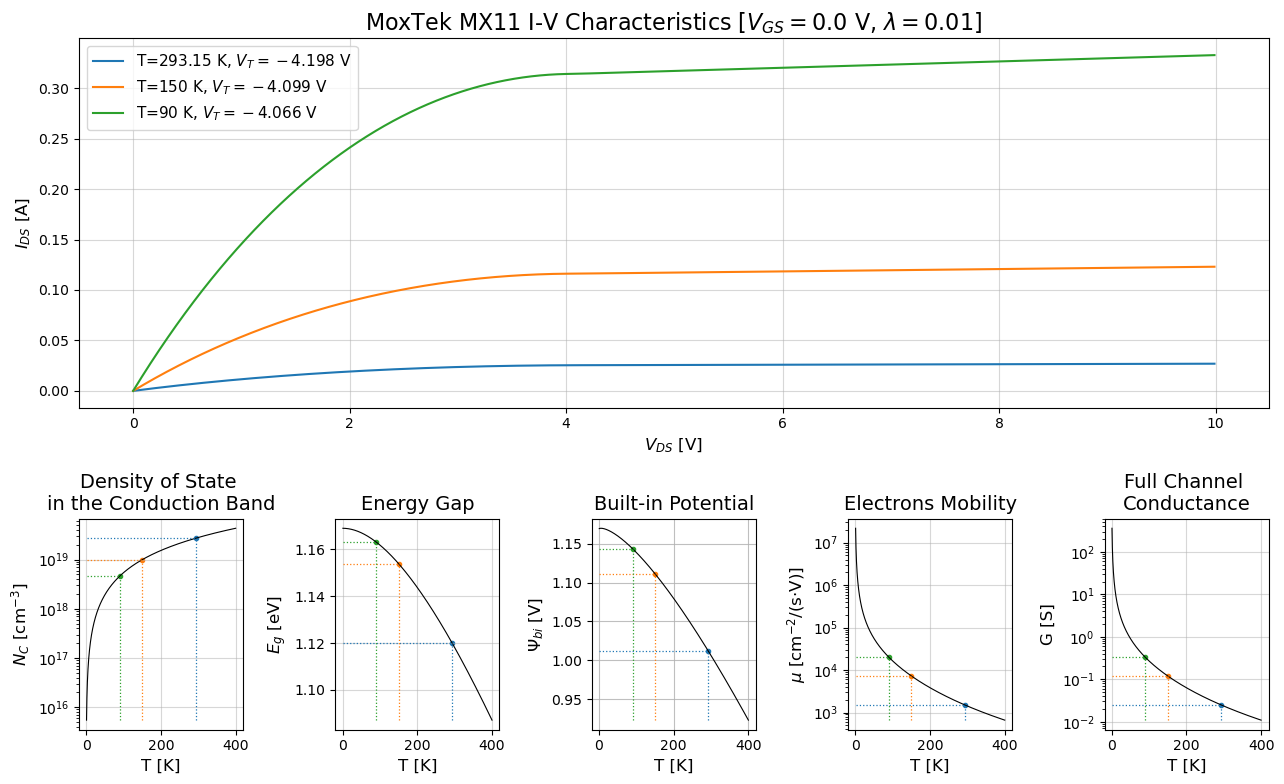

In [5]:
T_0 = MX11_data_sheet['nominal_T']
T_1 = 150
T_2 = 90
lambda_mod = 0.01
V_gs = 0.
T_values = [T_0,T_1,T_2]

# Initialize class
jfet=MX11_jfet

# Define ranges for plots
Ts = np.arange(1, 400, 0.1)
V_ds = np.arange(0,10,0.01)

# Compute quantities
id_values = [[jfet.I_d(V_ds=i, V_gs=V_gs, T=t, lambda_mod=lambda_mod) for i in V_ds] for t in T_values]
N_c = jfet.density_of_states_cond_band(Ts)
V_p = round(jfet.pinch_off_voltage(),2)
E_g = jfet.energy_gap(Ts)
V_bi = jfet.built_in_potential(Ts)
mu = [jfet.mobility(t) for t in Ts]
G = [jfet.full_channel_conductance(m) for m in mu]




# Plots
fig = plt.figure(figsize=(13, 8))
gs = fig.add_gridspec(2, 5, height_ratios=[1.75, 1])  

ax0 = fig.add_subplot(gs[0, :])  
for i, t in enumerate(T_values):
    ax0.plot(V_ds, id_values[i], label=f"T={t} K, $V_{{T}}={np.round(jfet.built_in_potential(t)-V_p,3)}$ V")
ax0.legend()
ax0.set_xlabel("$V_{DS}$ [V]")
ax0.set_ylabel("$I_{DS}$ [A]")
ax0.set_title(f"MoxTek MX11 I-V Characteristics [$V_{{GS}} = {V_gs}$ V, $\lambda = {lambda_mod}$]", fontsize=title_size)
ax0.grid(alpha=0.5)


ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(Ts, N_c, label="$N_c(T)$", color="black", lw=0.8)

ax1.scatter(T_0, jfet.density_of_states_cond_band(T_0), color="tab:blue", marker=".")
ax1.vlines(T_0,min(N_c),jfet.density_of_states_cond_band(T_0), color="tab:blue", ls="dotted", lw=0.9)
ax1.hlines(jfet.density_of_states_cond_band(T_0), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)

ax1.scatter(T_1, jfet.density_of_states_cond_band(T_1), color="tab:orange", marker=".")
ax1.vlines(T_1,min(N_c),jfet.density_of_states_cond_band(T_1), color="tab:orange", ls="dotted", lw=0.9)
ax1.hlines(jfet.density_of_states_cond_band(T_1), min(Ts), T_1, color="tab:orange", ls="dotted", lw=0.9)

ax1.scatter(T_2, jfet.density_of_states_cond_band(T_2), color="tab:green", marker=".")
ax1.vlines(T_2,min(N_c),jfet.density_of_states_cond_band(T_2), color="tab:green", ls="dotted", lw=0.9)
ax1.hlines(jfet.density_of_states_cond_band(T_2), min(Ts), T_2, color="tab:green", ls="dotted", lw=0.9)

ax1.set_yscale("log")
ax1.set_xlabel("T [K]")
ax1.set_ylabel("$N_C$ [cm$^{-3}$]")
ax1.set_title("Density of State \nin the Conduction Band")
ax1.grid(alpha=0.5)


ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(Ts, E_g, label="$\E_g(T)$", color="black", lw=0.8)

ax2.scatter(T_0, jfet.energy_gap(T_0), color="tab:blue", marker=".")
ax2.vlines(T_0,min(E_g),jfet.energy_gap(T_0), color="tab:blue", ls="dotted", lw=0.9)
ax2.hlines(jfet.energy_gap(T_0), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)

ax2.scatter(T_1, jfet.energy_gap(T_1), color="tab:orange", marker=".")
ax2.vlines(T_1,min(E_g),jfet.energy_gap(T_1), color="tab:orange", ls="dotted", lw=0.9)
ax2.hlines(jfet.energy_gap(T_1), min(Ts), T_1, color="tab:orange", ls="dotted", lw=0.9)

ax2.scatter(T_2, jfet.energy_gap(T_2), color="tab:green", marker=".")
ax2.vlines(T_2,min(E_g),jfet.energy_gap(T_2), color="tab:green", ls="dotted", lw=0.9)
ax2.hlines(jfet.energy_gap(T_2), min(Ts), T_2, color="tab:green", ls="dotted", lw=0.9)

ax2.set_xlabel("T [K]")
ax2.set_ylabel("$E_g$ [eV]")
ax2.set_title("Energy Gap")
ax2.grid(alpha=0.5)


ax3 = fig.add_subplot(gs[1, 2])
ax3.plot(Ts, V_bi, label="$\Psi_{bi}(T)$", color="black", lw=0.8)

ax3.scatter(T_0, jfet.built_in_potential(T_0), color="tab:blue", marker=".")
ax3.vlines(T_0,min(V_bi),jfet.built_in_potential(T_0), color="tab:blue", ls="dotted", lw=0.9)
ax3.hlines(jfet.built_in_potential(T_0), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)

ax3.scatter(T_1, jfet.built_in_potential(T_1), color="tab:orange", marker=".")
ax3.vlines(T_1,min(V_bi),jfet.built_in_potential(T_1), color="tab:orange", ls="dotted", lw=0.9)
ax3.hlines(jfet.built_in_potential(T_1), min(Ts), T_1, color="tab:orange", ls="dotted", lw=0.9)

ax3.scatter(T_2, jfet.built_in_potential(T_2), color="tab:green", marker=".")
ax3.vlines(T_2,min(V_bi),jfet.built_in_potential(T_2), color="tab:green", ls="dotted", lw=0.9)
ax3.hlines(jfet.built_in_potential(T_2), min(Ts), T_2, color="tab:green", ls="dotted", lw=0.9)

ax3.set_xlabel("T [K]")
ax3.set_ylabel("$\Psi_{bi}$ [V]")
ax3.set_title("Built-in Potential")
ax3.grid(alpha=0.8)


ax4 = fig.add_subplot(gs[1, 3])
ax4.plot(Ts, mu, label="$\mu(T)$", color="black", lw=0.8)

ax4.scatter(T_0, jfet.mobility(T_0), color="tab:blue", marker=".")
ax4.vlines(T_0,min(mu),jfet.mobility(T_0), color="tab:blue", ls="dotted", lw=0.9)
ax4.hlines(jfet.mobility(T_0), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)

ax4.scatter(T_1, jfet.mobility(T_1), color="tab:orange", marker=".")
ax4.vlines(T_1,min(mu),jfet.mobility(T_1), color="tab:orange", ls="dotted", lw=0.9)
ax4.hlines(jfet.mobility(T_1), min(Ts), T_1, color="tab:orange", ls="dotted", lw=0.9)

ax4.scatter(T_2, jfet.mobility(T_2), color="tab:green", marker=".")
ax4.vlines(T_2,min(mu),jfet.mobility(T_2), color="tab:green", ls="dotted", lw=0.9)
ax4.hlines(jfet.mobility(T_2), min(Ts), T_2, color="tab:green", ls="dotted", lw=0.9)

ax4.set_yscale("log")
ax4.set_xlabel("T [K]")
ax4.set_ylabel("$\mu$ [cm$^{-2}$/(s$\cdot$V)]")
ax4.set_title("Electrons Mobility")
ax4.grid(alpha=0.5)


ax5 = fig.add_subplot(gs[1, 4])
ax5.plot(Ts, G, label="$G(T)$", color="black", lw=0.8)

ax5.scatter(T_0, jfet.full_channel_conductance(jfet.mobility(T_0)), color="tab:blue", marker=".")
ax5.vlines(T_0,min(G),jfet.full_channel_conductance(jfet.mobility(T_0)), color="tab:blue", ls="dotted", lw=0.9)
ax5.hlines(jfet.full_channel_conductance(jfet.mobility(T_0)), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)

ax5.scatter(T_1, jfet.full_channel_conductance(jfet.mobility(T_1)), color="tab:orange", marker=".")
ax5.vlines(T_1,min(G),jfet.full_channel_conductance(jfet.mobility(T_1)), color="tab:orange", ls="dotted", lw=0.9)
ax5.hlines(jfet.full_channel_conductance(jfet.mobility(T_1)), min(Ts), T_1, color="tab:orange", ls="dotted", lw=0.9)

ax5.scatter(T_2, jfet.full_channel_conductance(jfet.mobility(T_2)), color="tab:green", marker=".")
ax5.vlines(T_2,min(G),jfet.full_channel_conductance(jfet.mobility(T_2)), color="tab:green", ls="dotted", lw=0.9)
ax5.hlines(jfet.full_channel_conductance(jfet.mobility(T_2)), min(Ts), T_2, color="tab:green", ls="dotted", lw=0.9)

ax5.set_yscale("log")
ax5.set_xlabel("T [K]")
ax5.set_ylabel("G [S]")
ax5.set_title("Full Channel \nConductance")
ax5.grid(alpha=0.5)

plt.tight_layout()

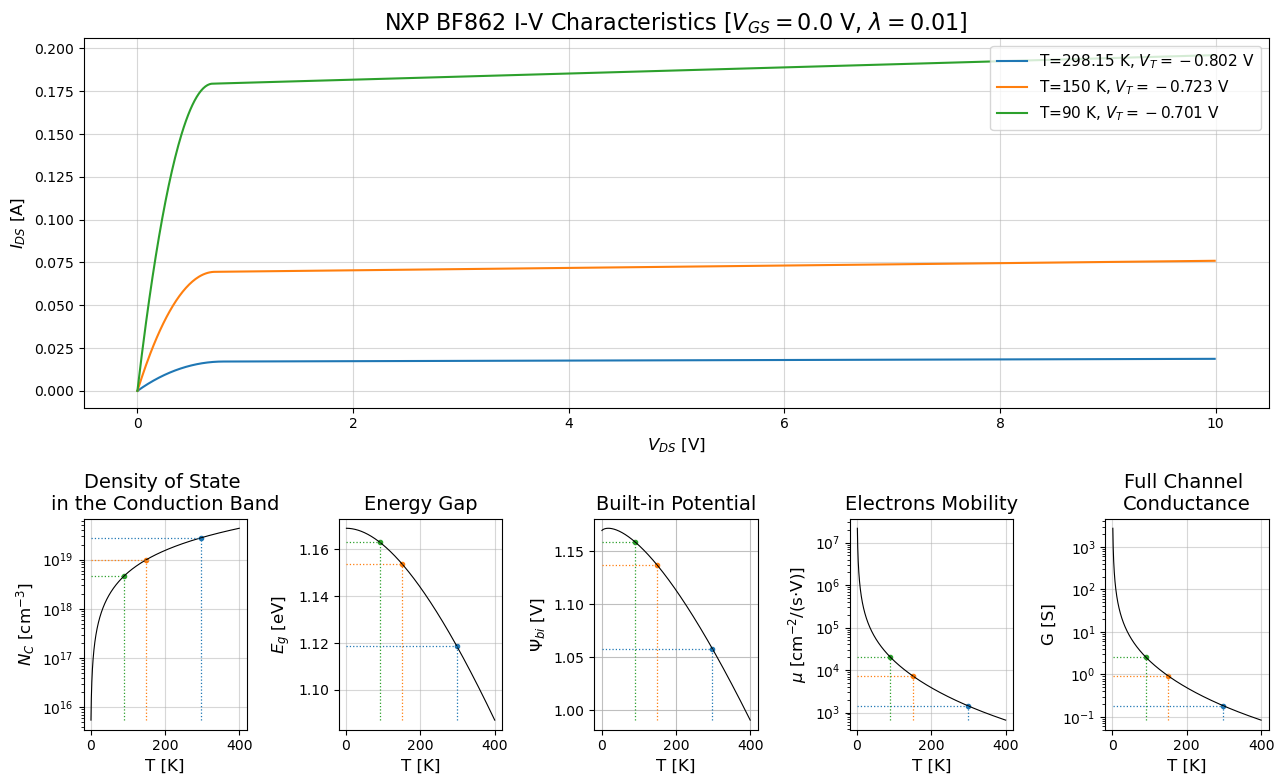

In [6]:
T_0 = BF862_data_sheet['nominal_T']
T_1 = 150
T_2 = 90
lambda_mod = 0.01
V_gs = 0.
T_values = [T_0,T_1,T_2]

# Initialize class
jfet=BF862_jfet

# Define ranges for plots
Ts = np.arange(1, 400, 0.1)
V_ds = np.arange(0,10,0.01)

# Compute quantities
id_values = [[jfet.I_d(V_ds=i, V_gs=V_gs, T=t, lambda_mod=lambda_mod) for i in V_ds] for t in T_values]
N_c = jfet.density_of_states_cond_band(Ts)
V_p = round(jfet.pinch_off_voltage(),2)
E_g = jfet.energy_gap(Ts)
V_bi = jfet.built_in_potential(Ts)
mu = [jfet.mobility(t) for t in Ts]
G = [jfet.full_channel_conductance(m) for m in mu]




# Plots
fig = plt.figure(figsize=(13, 8))
gs = fig.add_gridspec(2, 5, height_ratios=[1.75, 1])  

ax0 = fig.add_subplot(gs[0, :])  
for i, t in enumerate(T_values):
    ax0.plot(V_ds, id_values[i], label=f"T={t} K, $V_{{T}}={np.round(jfet.built_in_potential(t)-V_p,3)}$ V")
ax0.legend(loc='upper right')
ax0.set_xlabel("$V_{DS}$ [V]")
ax0.set_ylabel("$I_{DS}$ [A]")
ax0.set_title(f"NXP BF862 I-V Characteristics [$V_{{GS}} = {V_gs}$ V, $\lambda = {lambda_mod}$]", fontsize=title_size)
ax0.grid(alpha=0.5)


ax1 = fig.add_subplot(gs[1, 0])
ax1.plot(Ts, N_c, label="$N_c(T)$", color="black", lw=0.8)

ax1.scatter(T_0, jfet.density_of_states_cond_band(T_0), color="tab:blue", marker=".")
ax1.vlines(T_0,min(N_c),jfet.density_of_states_cond_band(T_0), color="tab:blue", ls="dotted", lw=0.9)
ax1.hlines(jfet.density_of_states_cond_band(T_0), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)

ax1.scatter(T_1, jfet.density_of_states_cond_band(T_1), color="tab:orange", marker=".")
ax1.vlines(T_1,min(N_c),jfet.density_of_states_cond_band(T_1), color="tab:orange", ls="dotted", lw=0.9)
ax1.hlines(jfet.density_of_states_cond_band(T_1), min(Ts), T_1, color="tab:orange", ls="dotted", lw=0.9)

ax1.scatter(T_2, jfet.density_of_states_cond_band(T_2), color="tab:green", marker=".")
ax1.vlines(T_2,min(N_c),jfet.density_of_states_cond_band(T_2), color="tab:green", ls="dotted", lw=0.9)
ax1.hlines(jfet.density_of_states_cond_band(T_2), min(Ts), T_2, color="tab:green", ls="dotted", lw=0.9)

ax1.set_yscale("log")
ax1.set_xlabel("T [K]")
ax1.set_ylabel("$N_C$ [cm$^{-3}$]")
ax1.set_title("Density of State \nin the Conduction Band")
ax1.grid(alpha=0.5)


ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(Ts, E_g, label="$\E_g(T)$", color="black", lw=0.8)

ax2.scatter(T_0, jfet.energy_gap(T_0), color="tab:blue", marker=".")
ax2.vlines(T_0,min(E_g),jfet.energy_gap(T_0), color="tab:blue", ls="dotted", lw=0.9)
ax2.hlines(jfet.energy_gap(T_0), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)

ax2.scatter(T_1, jfet.energy_gap(T_1), color="tab:orange", marker=".")
ax2.vlines(T_1,min(E_g),jfet.energy_gap(T_1), color="tab:orange", ls="dotted", lw=0.9)
ax2.hlines(jfet.energy_gap(T_1), min(Ts), T_1, color="tab:orange", ls="dotted", lw=0.9)

ax2.scatter(T_2, jfet.energy_gap(T_2), color="tab:green", marker=".")
ax2.vlines(T_2,min(E_g),jfet.energy_gap(T_2), color="tab:green", ls="dotted", lw=0.9)
ax2.hlines(jfet.energy_gap(T_2), min(Ts), T_2, color="tab:green", ls="dotted", lw=0.9)

ax2.set_xlabel("T [K]")
ax2.set_ylabel("$E_g$ [eV]")
ax2.set_title("Energy Gap")
ax2.grid(alpha=0.5)


ax3 = fig.add_subplot(gs[1, 2])
ax3.plot(Ts, V_bi, label="$\Psi_{bi}(T)$", color="black", lw=0.8)

ax3.scatter(T_0, jfet.built_in_potential(T_0), color="tab:blue", marker=".")
ax3.vlines(T_0,min(V_bi),jfet.built_in_potential(T_0), color="tab:blue", ls="dotted", lw=0.9)
ax3.hlines(jfet.built_in_potential(T_0), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)

ax3.scatter(T_1, jfet.built_in_potential(T_1), color="tab:orange", marker=".")
ax3.vlines(T_1,min(V_bi),jfet.built_in_potential(T_1), color="tab:orange", ls="dotted", lw=0.9)
ax3.hlines(jfet.built_in_potential(T_1), min(Ts), T_1, color="tab:orange", ls="dotted", lw=0.9)

ax3.scatter(T_2, jfet.built_in_potential(T_2), color="tab:green", marker=".")
ax3.vlines(T_2,min(V_bi),jfet.built_in_potential(T_2), color="tab:green", ls="dotted", lw=0.9)
ax3.hlines(jfet.built_in_potential(T_2), min(Ts), T_2, color="tab:green", ls="dotted", lw=0.9)

ax3.set_xlabel("T [K]")
ax3.set_ylabel("$\Psi_{bi}$ [V]")
ax3.set_title("Built-in Potential")
ax3.grid(alpha=0.8)


ax4 = fig.add_subplot(gs[1, 3])
ax4.plot(Ts, mu, label="$\mu(T)$", color="black", lw=0.8)

ax4.scatter(T_0, jfet.mobility(T_0), color="tab:blue", marker=".")
ax4.vlines(T_0,min(mu),jfet.mobility(T_0), color="tab:blue", ls="dotted", lw=0.9)
ax4.hlines(jfet.mobility(T_0), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)

ax4.scatter(T_1, jfet.mobility(T_1), color="tab:orange", marker=".")
ax4.vlines(T_1,min(mu),jfet.mobility(T_1), color="tab:orange", ls="dotted", lw=0.9)
ax4.hlines(jfet.mobility(T_1), min(Ts), T_1, color="tab:orange", ls="dotted", lw=0.9)

ax4.scatter(T_2, jfet.mobility(T_2), color="tab:green", marker=".")
ax4.vlines(T_2,min(mu),jfet.mobility(T_2), color="tab:green", ls="dotted", lw=0.9)
ax4.hlines(jfet.mobility(T_2), min(Ts), T_2, color="tab:green", ls="dotted", lw=0.9)

ax4.set_yscale("log")
ax4.set_xlabel("T [K]")
ax4.set_ylabel("$\mu$ [cm$^{-2}$/(s$\cdot$V)]")
ax4.set_title("Electrons Mobility")
ax4.grid(alpha=0.5)


ax5 = fig.add_subplot(gs[1, 4])
ax5.plot(Ts, G, label="$G(T)$", color="black", lw=0.8)

ax5.scatter(T_0, jfet.full_channel_conductance(jfet.mobility(T_0)), color="tab:blue", marker=".")
ax5.vlines(T_0,min(G),jfet.full_channel_conductance(jfet.mobility(T_0)), color="tab:blue", ls="dotted", lw=0.9)
ax5.hlines(jfet.full_channel_conductance(jfet.mobility(T_0)), min(Ts), T_0, color="tab:blue", ls="dotted", lw=0.9)

ax5.scatter(T_1, jfet.full_channel_conductance(jfet.mobility(T_1)), color="tab:orange", marker=".")
ax5.vlines(T_1,min(G),jfet.full_channel_conductance(jfet.mobility(T_1)), color="tab:orange", ls="dotted", lw=0.9)
ax5.hlines(jfet.full_channel_conductance(jfet.mobility(T_1)), min(Ts), T_1, color="tab:orange", ls="dotted", lw=0.9)

ax5.scatter(T_2, jfet.full_channel_conductance(jfet.mobility(T_2)), color="tab:green", marker=".")
ax5.vlines(T_2,min(G),jfet.full_channel_conductance(jfet.mobility(T_2)), color="tab:green", ls="dotted", lw=0.9)
ax5.hlines(jfet.full_channel_conductance(jfet.mobility(T_2)), min(Ts), T_2, color="tab:green", ls="dotted", lw=0.9)

ax5.set_yscale("log")
ax5.set_xlabel("T [K]")
ax5.set_ylabel("G [S]")
ax5.set_title("Full Channel \nConductance")
ax5.grid(alpha=0.5)

plt.tight_layout()